# Traffic Sign Classification

---


## Loading the datasets

In [1]:
# Load pickled data
import pickle

training_file = '../traffic-signs-data/train.p'
validation_file= '../traffic-signs-data/valid.p'
testing_file = '../traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

X_train_clean = X_train
X_valid_clean = X_valid
X_test_clean = X_test

y_train_clean = y_train
y_valid_clean = y_valid
y_test_clean = y_test

print('Input data loaded')

Input data loaded


---
## Dataset summary & exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

### Summary of the Datasets

In [2]:
import numpy as np
from collections import defaultdict

# Number of training examples
n_train = np.shape(X_train)[0]

# Number of validation examples
n_validation = np.shape(X_valid)[0]

# Number of testing examples.
n_test = np.shape(X_test)[0]

# What's the shape of a traffic sign image?
image_shape = np.shape(X_train)[1:3]

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

class_indices = defaultdict(list)
for c in range(n_classes):
    for i in range(n_train):
        if y_train_clean[i] == c:
            class_indices[c].append(i)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Image data shape =", np.shape(y_train))
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Image data shape = (34799,)
Number of classes = 43


### Visualising the training set

In [3]:
import pandas as pd
import csv
import random
import matplotlib.pyplot as plt
%matplotlib inline

traffic_db = pd.read_csv('./signnames.csv')

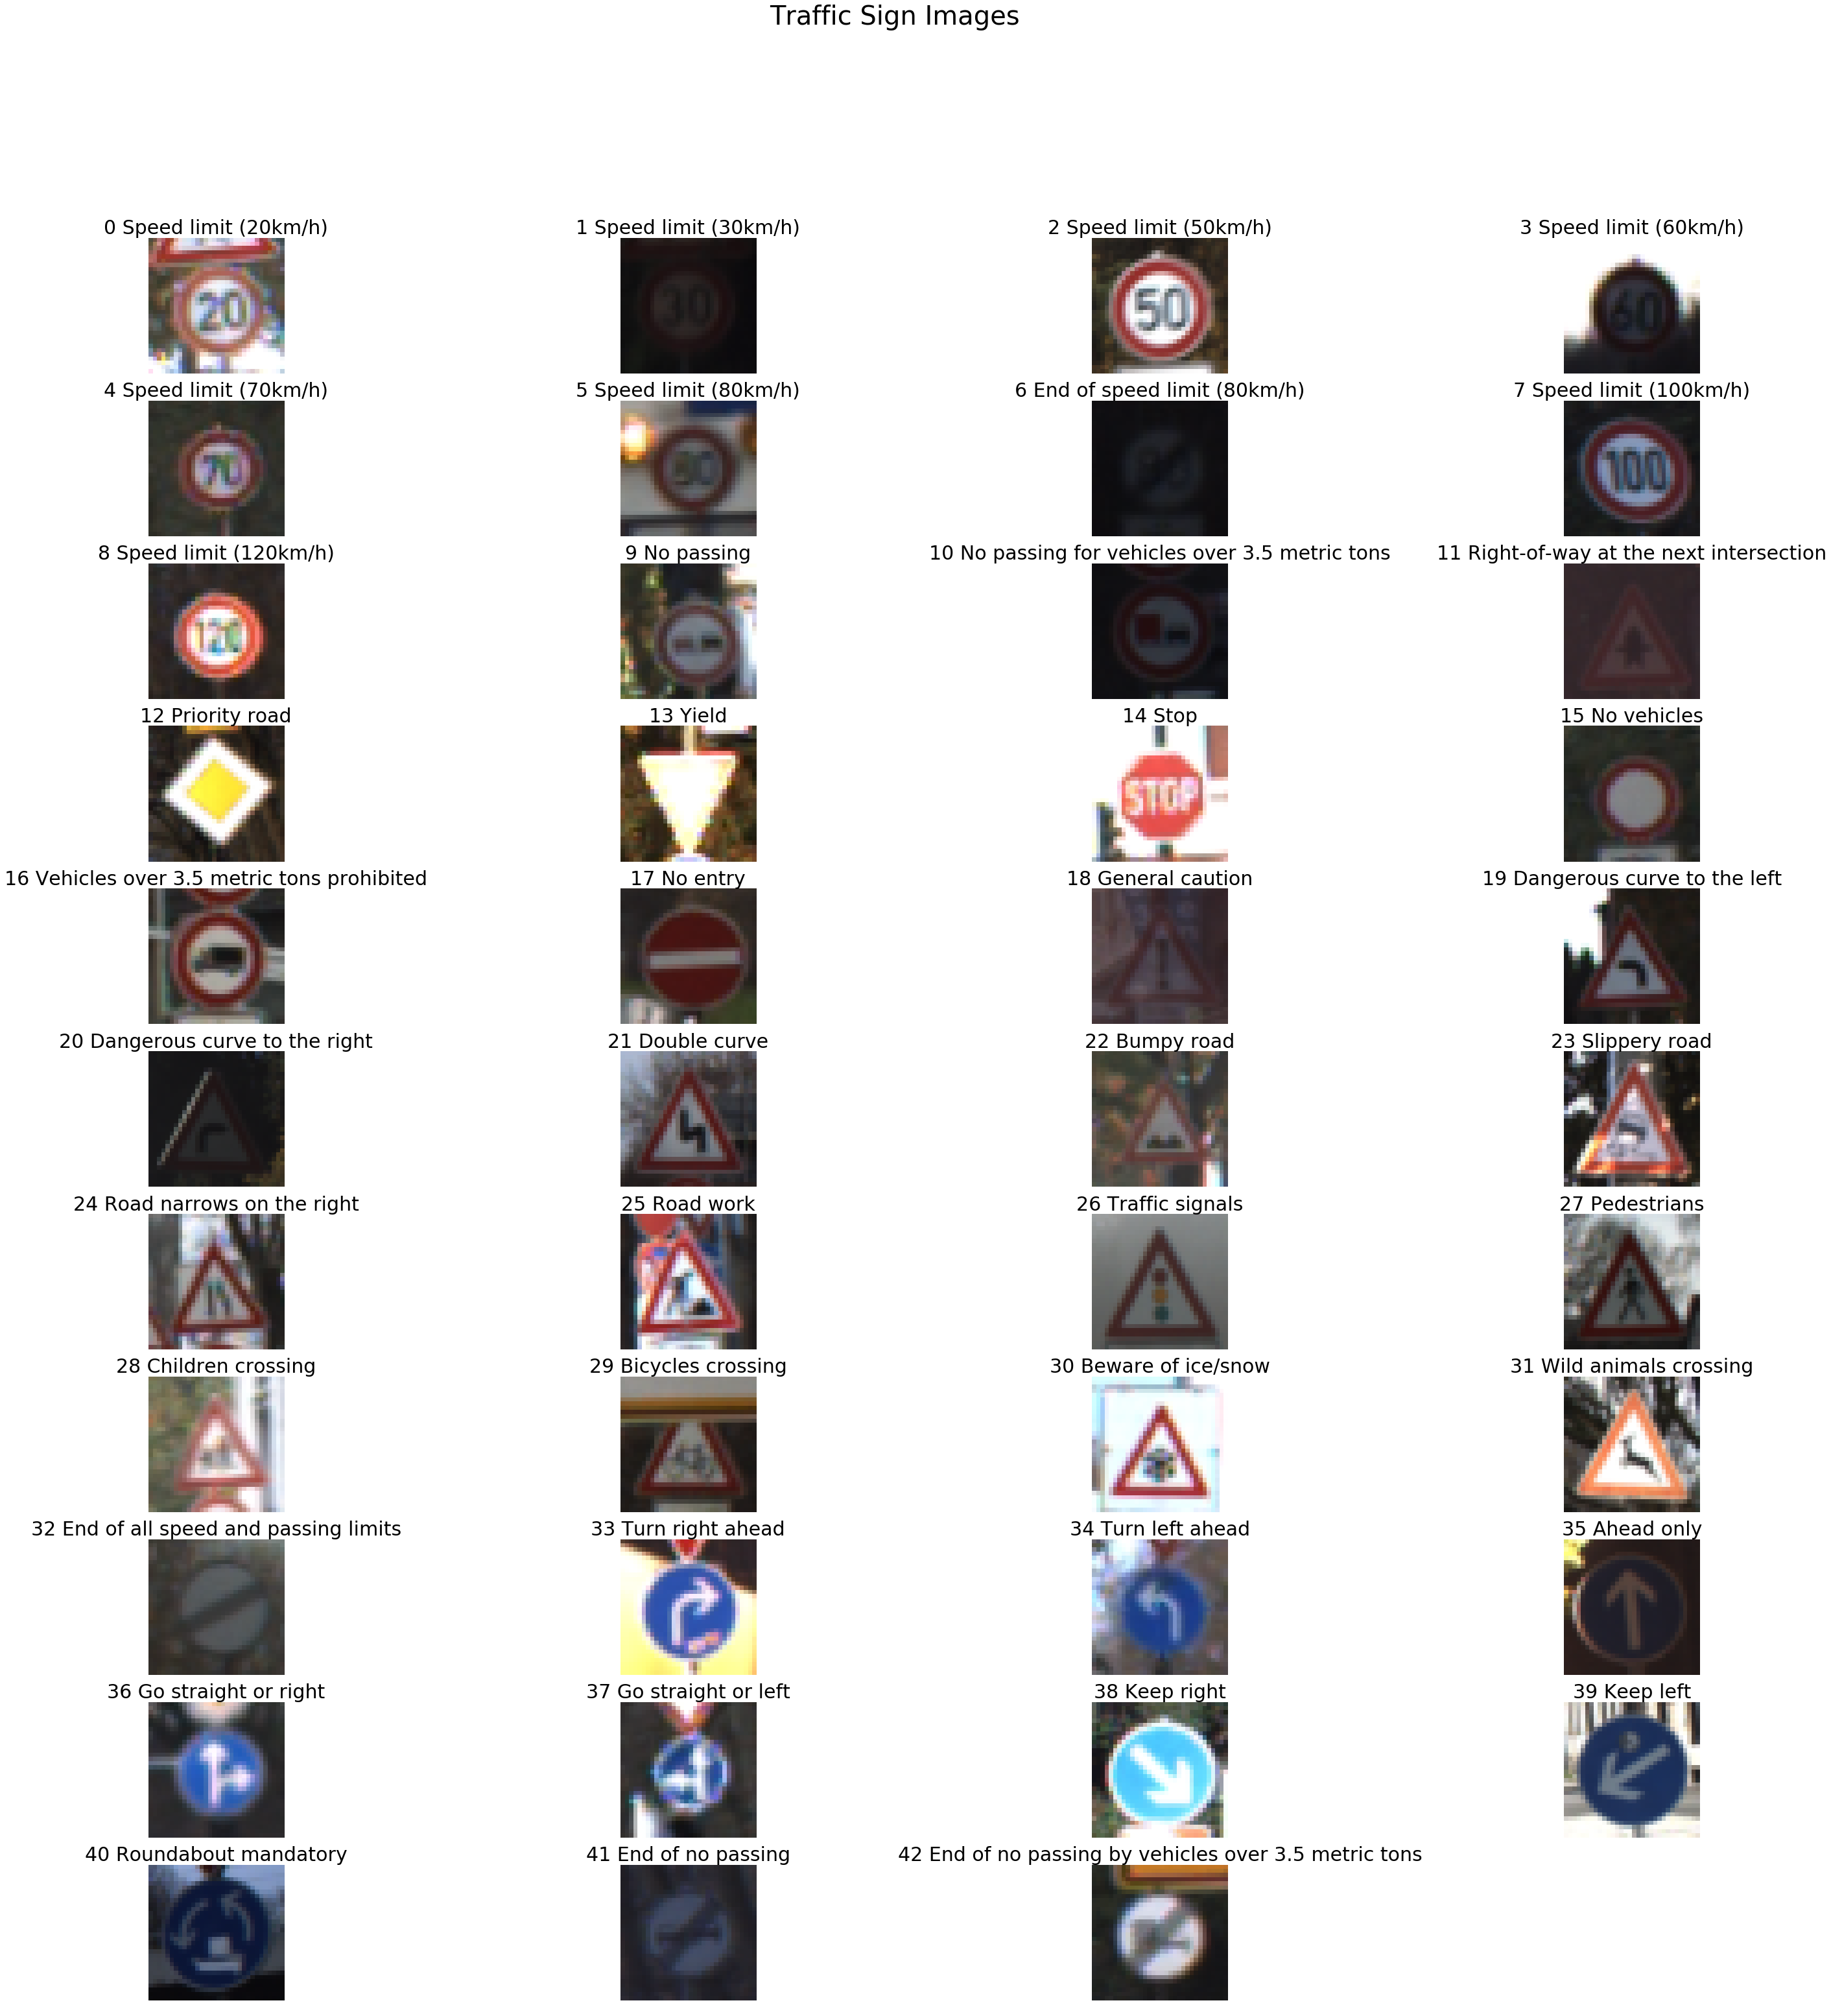

In [4]:
fig = plt.figure(figsize=(50, 50))
fig.suptitle('Traffic Sign Images', fontsize=40)
for id in traffic_db['ClassId']:
    fig.add_subplot(11, 4, id+1)
    plt.title(str(id)+' '+traffic_db['SignName'][id], fontsize=30)
    plt.axis('off')
    plt.imshow(X_train_clean[random.choice(class_indices[id])])

### Number of images per class

This histogram shows the distribution of images across the traffic sign classes. Some classes are better represented than others in this dataset.

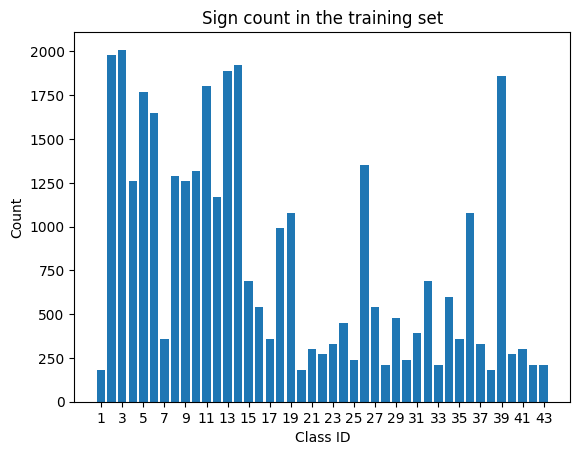

In [5]:
import matplotlib.pyplot as plt; plt.rcdefaults()
 
count=[]
for i in range(43):
    count.append(len(class_indices[i]))
plt.bar(range(43), count)
plt.xticks(range(0,43,2), range(1,44,2))
plt.ylabel('Count')
plt.xlabel('Class ID')
plt.title('Sign count in the training set')

---
## Data preprocessing

In this section, the entire training set is grayscaled. To address the spiky histogram, additional images are generated by augmenting existing images from the poorly represented classes, until each class is equally represented.

In [6]:
from skimage.color import rgb2gray, rgb2yuv
from sklearn.utils import shuffle
from scipy.ndimage.interpolation import rotate
from collections import defaultdict
import random

def rotate_image(x, angle):
    return rotate(input=x, angle=angle, axes=(0, 1), reshape=False,
                  order=0, mode='constant', cval=0.0, prefilter=True)

def print_shape(x):
    print(np.shape(x))

def convert_to_gray(X, name=''):
    print('Converting', name, 'to grayscale')
    X = rgb2gray(X)
    X = np.expand_dims(X, axis=3)
    return X

In [7]:
class_indices = defaultdict(list)
for c in range(n_classes):
    for i in range(n_train):
        if y_train_clean[i] == c:
            class_indices[c].append(i)

X_train = convert_to_gray(X_train_clean, 'X_train')
#X_train = X_train_clean
y_train = y_train_clean

X_valid = convert_to_gray(X_valid_clean, 'X_valid')
#X_valid = X_valid_clean
y_valid = y_valid_clean

X_test = convert_to_gray(X_test_clean, 'X_test')
#X_test = X_test_clean
y_test = y_test_clean

print('Augmenting training set (rotation only)')

for i in range(n_classes):
    num_more_images = 3500 - np.sum(y_train == i)
    angles = np.random.random_sample(num_more_images)*30-15
    X_more = []
    y_more = []
    for j in range(num_more_images):
        rotated = rotate_image(X_train[random.choice(class_indices[i])], angles[j])
        X_more.append(rotated)
        y_more.append(i)
    X_train = np.concatenate((X_train, X_more), axis=0)
    y_train = np.append(y_train, y_more)

print('Preprocessing done')

Converting X_train to grayscale
Converting X_valid to grayscale
Converting X_test to grayscale
Augmenting training set (rotation only)
Preprocessing done


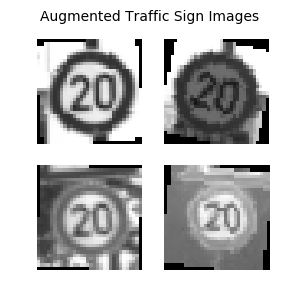

In [8]:
X_train, y_train = shuffle(X_train, y_train)

class_indices_new = defaultdict(list)
for c in range(n_classes):
    for i in range(np.shape(X_train)[0]):
        if y_train[i] == c:
            class_indices_new[c].append(i)

class_id = random.choice(range(43))

images = [X_train[random.choice(class_indices_new[class_id])].squeeze()]
images.append(X_train[random.choice(class_indices_new[class_id])].squeeze())
images.append(X_train[random.choice(class_indices_new[class_id])].squeeze())
images.append(X_train[random.choice(class_indices_new[class_id])].squeeze())

## Plotting traffic sign images
fig = plt.figure(figsize=(3, 3))
fig.suptitle('Augmented Traffic Sign Images', fontsize=10)
image_index=0
for image in images:
    image_index+=1
    fig.add_subplot(2, 2, image_index)
    #plt.title(str(id)+' '+traffic_db['SignName'][id], fontsize=30)
    plt.axis('off')
    plt.imshow(image, cmap='gray')

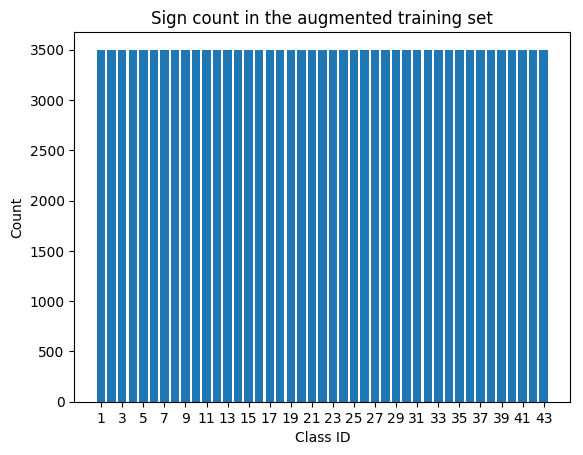

In [9]:
## Plotting the count of each sign
import matplotlib.pyplot as plt; plt.rcdefaults()
 
count=[]
for i in range(43):
    count.append(len(class_indices_new[i]))
plt.bar(range(43), count)
plt.xticks(range(0,43,2), range(1,44,2))
plt.ylabel('Count')
plt.xlabel('Class ID')
plt.title('Sign count in the augmented training set')

---
## Model architecture

In [10]:
import tensorflow as tf

from tensorflow.contrib.layers import flatten

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    return tf.nn.bias_add(x, b)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='VALID')

def dimensions(inheight, inwidth, outheight, outwidth, strides):
    return (np.ceil(float(inheight - outheight + 1) / float(strides[1])),
            np.ceil(float(inwidth - outwidth + 1) / float(strides[2])))

def LeNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    W = { # height, width, input_depth, output_depth
        'layer_1' : tf.Variable(tf.truncated_normal([7, 7, 1, 6], mu, sigma)),
        'layer_2' : tf.Variable(tf.truncated_normal([6, 6, 6, 16], mu, sigma)),
        'layer_3' : tf.Variable(tf.truncated_normal([256, 120], mu, sigma)),
        'layer_4' : tf.Variable(tf.truncated_normal([120, 84], mu, sigma)),
        'layer_5' : tf.Variable(tf.truncated_normal([84, n_classes], mu, sigma))}

    B = { # output_depth,
        'layer_1' : tf.Variable(tf.truncated_normal([6,], mu, sigma)),
        'layer_2' : tf.Variable(tf.truncated_normal([16,], mu, sigma)),
        'layer_3' : tf.Variable(tf.truncated_normal([120,], mu, sigma)),
        'layer_4' : tf.Variable(tf.truncated_normal([84,], mu, sigma)),
        'layer_5' : tf.Variable(tf.truncated_normal([n_classes,], mu, sigma))}

    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    layer_1 = conv2d(x, W['layer_1'], B['layer_1'])

    # Activation.
    layer_1 = tf.nn.relu(layer_1)
    
    layer_1 = tf.nn.dropout(layer_1, keep_prob)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    layer_1 = maxpool2d(layer_1)
    
   
    # Layer 2: Convolutional. Output = 10x10x16.
    layer_2 = conv2d(layer_1, W['layer_2'], B['layer_2'])
    
    # Activation.
    layer_2 = tf.nn.relu(layer_2)
    
    layer_2 = tf.nn.dropout(layer_2, keep_prob)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    layer_2 = maxpool2d(layer_2)

    # Flatten. Input = 5x5x16. Output = 400.
    layer_2 = flatten(layer_2)
    
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    layer_3 = tf.add(tf.matmul(layer_2, W['layer_3']), B['layer_3'])
    
    # Activation.
    layer_3 = tf.nn.relu(layer_3)
    
    layer_3 = tf.nn.dropout(layer_3, keep_prob)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    layer_4 = tf.add(tf.matmul(layer_3, W['layer_4']), B['layer_4'])

    # Activation.
    layer_4 = tf.nn.relu(layer_4)
    
    layer_4 = tf.nn.dropout(layer_4, keep_prob)

    
    # Layer 5: Fully Connected. Input = 84. Output = 10.
    logits = tf.add(tf.matmul(layer_4, W['layer_5']), B['layer_5'])
    
    return logits

---
## Training and validation

In [11]:
x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)


EPOCHS = 10
BATCH_SIZE = 32

global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.0005
rate = tf.train.exponential_decay(starter_learning_rate, global_step, 100000, 0.96, staircase=True)

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)


correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.75})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.885

EPOCH 2 ...
Validation Accuracy = 0.921

EPOCH 3 ...
Validation Accuracy = 0.930

EPOCH 4 ...
Validation Accuracy = 0.937

EPOCH 5 ...
Validation Accuracy = 0.942

EPOCH 6 ...
Validation Accuracy = 0.941

EPOCH 7 ...
Validation Accuracy = 0.945

EPOCH 8 ...
Validation Accuracy = 0.960

EPOCH 9 ...
Validation Accuracy = 0.944

EPOCH 10 ...
Validation Accuracy = 0.953

Model saved


---
## Testing

In [12]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.933


---

## Testing the model on new images

To provide more insight into how the model is performing, five pictures of German traffic signs were downloaded from the web and tested on the model.

### The new images

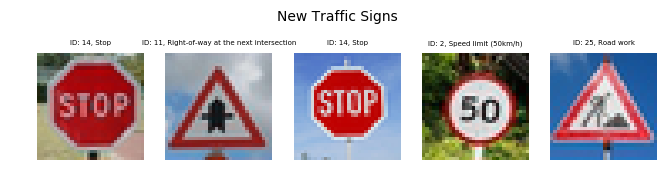

In [13]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
from sklearn.utils import shuffle

images = plt.imread('./german_traffic_signs/image1_classid2.jpg')
images = np.expand_dims(images, axis=0)
images = np.insert(images, 1, plt.imread('./german_traffic_signs/image2_classid14.jpg'), axis=0)
images = np.insert(images, 2, plt.imread('./german_traffic_signs/image3_classid11.jpg'), axis=0)
images = np.insert(images, 3, plt.imread('./german_traffic_signs/image4_classid25.jpg'), axis=0)
images = np.insert(images, 4, plt.imread('./german_traffic_signs/image5_classid14.jpg'), axis=0)

labels = [2, 14, 11, 25, 14]

images, labels = shuffle(images, labels)

fig = plt.figure(figsize=(8, 2))
fig.suptitle('New Traffic Signs', fontsize=10)
image_index=0
for image in images:
    fig.add_subplot(1, 5, image_index+1)
    plt.title('ID: '+str(labels[image_index])+', '+traffic_db['SignName'][labels[image_index]], fontsize=5)
    plt.axis('off')
    plt.imshow(image.squeeze())
    image_index+=1
plt.show()

### The model's predicition

In [14]:
images = convert_to_gray(images)

Converting  to grayscale


In [15]:
soft_max = tf.nn.softmax(logits)

def evaluate(X_data, y_data):
    sess = tf.get_default_session()
    accuracy = sess.run(soft_max, feed_dict={x: X_data, y: y_data, keep_prob: 1})
    return accuracy

predictions = []

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    for image, label in zip(images, labels):
        print("Predicting label {} ...".format(label))
        image_accuracy = evaluate(np.expand_dims(image, axis=0), label)
        predictions.append(image_accuracy)
        print("Image Accuracy = {:.3f}".format(max(image_accuracy[0])))

Predicting label 14 ...
Image Accuracy = 1.000
Predicting label 11 ...
Image Accuracy = 1.000
Predicting label 14 ...
Image Accuracy = 1.000
Predicting label 2 ...
Image Accuracy = 0.641
Predicting label 25 ...
Image Accuracy = 0.999


### Performance analysis

In [16]:
score = 0

for pred, label in zip(predictions, labels):
    index = np.argmax(pred)
    if index == label: score += 20

print('Model predicted with '+str(score)+'% accuracy')

Model predicted with 80% accuracy


### The top 5 softmax probabilities for each image

The top 5 softmax probabilities shows the certainty of the model's predictions. `tf.nn.top_k` returns the values and class ids of the top k predictions.

In [17]:
soft_max = tf.nn.softmax(logits)
top_5 = tf.nn.top_k(soft_max, k = 5)

def evaluate(X_data, y_data):
    sess = tf.get_default_session()
    return sess.run(top_5, feed_dict={x: X_data, y: y_data, keep_prob: 1})

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    for image, label in zip(images, labels):
        print("Predicting label {} ...".format(label))
        print(evaluate(np.expand_dims(image, axis=0), label))

Predicting label 14 ...
TopKV2(values=array([[  9.99997139e-01,   1.40191332e-06,   8.31320165e-07,
          6.24526535e-07,   2.02065795e-08]], dtype=float32), indices=array([[14, 17, 38, 12, 13]], dtype=int32))
Predicting label 11 ...
TopKV2(values=array([[  1.00000000e+00,   5.67678717e-11,   9.13540598e-16,
          4.98355487e-16,   1.95609726e-16]], dtype=float32), indices=array([[11, 30,  6, 21,  3]], dtype=int32))
Predicting label 14 ...
TopKV2(values=array([[  9.99994755e-01,   4.07474135e-06,   4.62626787e-07,
          3.69565669e-07,   2.22533487e-07]], dtype=float32), indices=array([[14, 17, 13, 33, 38]], dtype=int32))
Predicting label 2 ...
TopKV2(values=array([[ 0.64135683,  0.17196137,  0.08744894,  0.08717378,  0.0092421 ]], dtype=float32), indices=array([[7, 5, 2, 3, 1]], dtype=int32))
Predicting label 25 ...
TopKV2(values=array([[  9.99454319e-01,   2.27504992e-04,   1.58017589e-04,
          1.11130612e-04,   2.66466850e-05]], dtype=float32), indices=array([[25, 3

---
## _Uncompleted_ - Visualising the internal state of the network

This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [18]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")